In [1]:
# Import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py
#from statsmodels.stats import shapiro
#from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats

# allow multiple outputs in jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display to show all rows
pd.set_option('display.max_rows', None)

# set display to show all columns
pd.set_option("display.max.columns", None)

### Load County Health Rankings Data

In [2]:
#'v060_rawvalue', 'v154_rawvalue', 'v062_rawvalue', 'v132_rawvalue', 'v005_rawvalue', 'v061_rawvalue'   
#diabetes, severe housing cost burden, access to exercise opportunities, preventible hospital stays, HIV prevelance

In [3]:
# import data into county_health_data data frame
county_health_rank = pd.read_csv('county_health_2021.csv')

# rename headers using 1st row of data
county_health_rank = county_health_rank.rename(columns=county_health_rank.iloc[0])

# delete 1st row (which is now a duplicate of the header)
county_health_rank = county_health_rank.drop(county_health_rank.index[0])

# view first 5 rows of county_health_data data frame (note that there appears to be no index 0)
#county_health_rank.head()

# select only desired columns
cols = ['statecode', 'countycode', 'fipscode', 'state', 'county', 'v166_rawvalue', 'v003_rawvalue', 'v004_rawvalue', 'v153_rawvalue',
        'v060_rawvalue', 'v154_rawvalue', 'v062_rawvalue', 'v132_rawvalue', 'v005_rawvalue', 'v061_rawvalue']

county_health_rank = county_health_rank[cols]

# view first 5 rows
county_health_rank.head()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

,statecode,countycode,fipscode,state,county,v166_rawvalue,v003_rawvalue,v004_rawvalue,v153_rawvalue,v060_rawvalue,v154_rawvalue,v062_rawvalue,v132_rawvalue,v005_rawvalue,v061_rawvalue
1,00,000,00000,US,United States,0.826664922,0.1244966054,0.0007581256,0.6399214141,0.105,0.1443735922,0.002612056,0.8416869169,4236,372.8
2,01,000,01000,AL,Alabama,0.7639912993,0.1514929638,0.0006520221,0.6878059932,0.145,0.1205779357,0.0010829695,0.6111228737,5466,330.4
3,01,001,01001,AL,Autauga County,0.8056736926,0.1300796103,0.0004676175,0.7329064822,0.127,0.1337588929,0.0002863842,0.6913012406,6650,230.2
4,01,003,01003,AL,Baldwin County,0.8181638453,0.1675343756,0.000701764,0.7524527369,0.103,0.1117404539,0.000985513,0.7371354895,3471,169.3
5,01,005,01005,AL,Barbour County,0.6052434457,0.1767323062,0.0003215305,0.608988764,0.175,0.1427071179,0.0001215264,0.5316676986,5314,471


In [4]:
# rename variables
county_health_rank.rename(columns={"v166_rawvalue": "broadband", "v003_rawvalue": "uninsured_adults", "v004_rawvalue": "primary_phys",
                                   "v153_rawvalue": "home_ownership", "v060_rawvalue": "diabetes", "v154_rawvalue": 'severe_housing_cost', 
                                   "v132_rawvalue": "access_exercise", "v062_rawvalue": "mental_hlth", "v005_rawvalue": "prevent_hosp_stay",
                                   "v061_rawvalue": "HIV_prev"}, inplace=True)
# select variables
select = ["broadband","uninsured_adults","primary_phys","home_ownership","diabetes","severe_housing_cost", "access_exercise", 
          "mental_hlth", "prevent_hosp_stay","HIV_prev"]

# determine data type of above variables
county_health_rank[select].dtypes

# convert data type of above variables from object to float or int
county_health_rank[select] = county_health_rank[select].astype(float)
county_health_rank['fipscode'] = county_health_rank['fipscode'].astype(int)

broadband              object
uninsured_adults       object
primary_phys           object
home_ownership         object
diabetes               object
severe_housing_cost    object
access_exercise        object
mental_hlth            object
prevent_hosp_stay      object
HIV_prev               object
dtype: object

### Load Excess Deaths Data

In [5]:
# import data into excess deaths data frame
deaths = pd.read_csv('ExcessDeaths_Obesity.csv')

# rename columns
deaths.rename(columns={'CountyName': 'county_name', 'TOTPOP_CY': 'total_county_pop', 'Deaths': 'total_deaths', 
                              'Expected': 'expected_deaths', 'Abnormal': 'abnormal_deaths', 'Excess': 'excess_deaths'}, inplace=True)

# check data type of Excess deaths column
deaths['excess_deaths'].dtypes

# select only needed columns
cols_2 = ['ID','county_name','State','total_county_pop','total_deaths','expected_deaths','abnormal_deaths','excess_deaths','COVID19']
deaths = deaths[cols_2]

# display first 5 rows
deaths.head()

dtype('int64')

,ID,county_name,State,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,1001,Autauga County,AL,57692,404,387,17,17,28
1,1003,Baldwin County,AL,219443,1775,1841,-66,0,94
2,1005,Barbour County,AL,27401,220,232,-12,0,16
3,1007,Bibb County,AL,23276,155,196,-41,0,19
4,1009,Blount County,AL,59231,397,541,-144,0,12


### Load Google Street View Features Data

In [6]:
# import google street view file
gsv = pd.read_csv('gsv_indicators_summarized_county.csv')

# rename columns
gsv.rename(columns={'county': 'fipscode'}, inplace=True)

# first 5 rows
gsv.head()

# check data type of county column
gsv['fipscode'].dtypes

,fipscode,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,1001,0.969148,0.005288,0.089308,0.677698,0,0.343879,0.085365,0.083976
1,1003,0.947018,0.007764,0.116095,0.677067,0,0.436140,0.108644,0.097183
2,1005,0.978433,0.004444,0.102145,0.665148,0,0.277878,0.043388,0.071833
3,1007,0.992821,0.002094,0.046022,0.732843,0,0.242073,0.035595,0.054354
4,1009,0.972386,0.002662,0.115099,0.674392,0,0.358319,0.032216,0.087506


dtype('int64')

### Load County Shapefile

In [7]:
# read in counties shapefile
counties = gpd.read_file('county_files/tl_2021_us_county.shp')

# first 5 rows
counties.head()

# convert GEOID column to integer
counties['GEOID'] = counties['GEOID'].astype(int)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.38368 34.69213, -104.37658 34.6..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.04802 40.35066, -98.04674 40.350..."


### Join datasets together

In [8]:
# join excess deaths and county health rankings dataframes
excess_county_hlth = pd.merge(county_health_rank,deaths,left_on='fipscode',right_on='ID')

# check data type
excess_county_hlth.dtypes

# remove duplicate info
excess_county_hlth.drop(['ID', 'county_name', 'State'], axis=1, inplace=True)

# check results
excess_county_hlth.head()

# drop rows with NaN
excess_county_hlth = excess_county_hlth.dropna()
excess_county_hlth.isna().sum().sum() #check if successful

statecode               object
countycode              object
fipscode                 int64
state                   object
county                  object
broadband              float64
uninsured_adults       float64
primary_phys           float64
home_ownership         float64
diabetes               float64
severe_housing_cost    float64
mental_hlth            float64
access_exercise        float64
prevent_hosp_stay      float64
HIV_prev               float64
ID                       int64
county_name             object
State                   object
total_county_pop         int64
total_deaths             int64
expected_deaths          int64
abnormal_deaths          int64
excess_deaths            int64
COVID19                  int64
dtype: object

,statecode,countycode,fipscode,state,county,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,01,001,1001,AL,Autauga County,0.805674,0.130080,0.000468,0.732906,0.127,0.133759,0.000286,0.691301,6650.0,230.2,57692,404,387,17,17,28
1,01,003,1003,AL,Baldwin County,0.818164,0.167534,0.000702,0.752453,0.103,0.111740,0.000986,0.737135,3471.0,169.3,219443,1775,1841,-66,0,94
2,01,005,1005,AL,Barbour County,0.605243,0.176732,0.000322,0.608989,0.175,0.142707,0.000122,0.531668,5314.0,471.0,27401,220,232,-12,0,16
3,01,007,1007,AL,Bibb County,0.692062,0.134299,0.000536,0.744159,0.136,0.087444,0.000268,0.162514,6690.0,235.0,23276,155,196,-41,0,19
4,01,009,1009,AL,Blount County,0.730081,0.179347,0.000207,0.787787,0.146,0.078048,0.000173,0.156345,4440.0,90.9,59231,397,541,-144,0,12


0

In [10]:
# Merge counties and gsv_features
gsv_counties = pd.merge(counties, gsv, left_on='GEOID', right_on='fipscode')

gsv_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,fipscode,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",31039,0.500000,0.000000,1.000000,0.500000,0,1.000000,0.000000,0.000000
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3...",53069,0.974623,0.005155,0.201031,0.327914,0,0.308485,0.056305,0.139175
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.38368 34.69213, -104.37658 34.6...",35011,0.380463,0.006846,0.699842,0.629015,0,0.535545,0.019747,0.230121
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045...",31109,0.865250,0.017866,0.226208,0.769947,0,0.448079,0.283628,0.170508
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.04802 40.35066, -98.04674 40.350...",31129,0.649414,0.009766,0.507324,0.574219,0,0.596680,0.147949,0.259766


In [11]:
# join gsv_counties and excess_county_hlth dataframes
gsv_deaths_hlth = pd.merge(gsv_counties, excess_county_hlth, left_on='GEOID', right_on='fipscode')

# remove uneeded columns
gsv_deaths_hlth.drop(['STATEFP', 'COUNTYFP', 'fipscode_x','statecode','countycode','fipscode_y','county', 'LSAD', 'CLASSFP',
                     'MTFCC','CSAFP','METDIVFP','FUNCSTAT','CBSAFP'], axis=1, inplace=True)

gsv_deaths_hlth.head()

,COUNTYNS,GEOID,NAME,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,state,broadband,uninsured_adults,primary_phys,home_ownership,diabetes,severe_housing_cost,mental_hlth,access_exercise,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19
0,00835876,31109,Lancaster,Lancaster County,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045...",0.865250,0.017866,0.226208,0.769947,0,0.448079,0.283628,0.170508,NE,0.877039,0.096995,0.000706,0.597986,0.082,0.120426,0.003833,0.969030,3245.0,29.5,323229,2343,1744,599,599,101
1,00277310,6091,Sierra,Sierra County,2468694582,23299110,+39.5769252,-120.5219926,"POLYGON ((-120.55587 39.50874, -120.55614 39.5...",0.813906,0.008691,0.410020,0.587935,0,0.389059,0.135481,0.368098,CA,0.748294,0.080593,0.000335,0.753601,0.070,0.197205,0.001664,0.701852,2310.0,227.5,3214,28,33,-5,0,0
2,00161539,1027,Clay,Clay County,1564255426,5281616,+33.2703999,-085.8635254,"POLYGON ((-85.65202 33.25238, -85.65203 33.251...",0.977837,0.001753,0.090541,0.706123,0,0.159953,0.013172,0.091575,AL,0.701039,0.198139,0.000377,0.754521,0.162,0.071677,0.000151,0.637812,6054.0,175.5,13802,159,138,21,21,30
3,00069902,5137,Stone,Stone County,1570673294,8145444,+35.8570011,-092.1404819,"POLYGON ((-91.99105 35.93176, -91.99091 35.931...",0.978604,0.001973,0.126176,0.548027,0,0.294537,0.039074,0.108118,AR,0.506163,0.149020,0.000482,0.746396,0.144,0.126306,0.001040,0.575036,5178.0,92.7,13352,134,134,0,0,15
4,00695754,28061,Jasper,Jasper County,1751636189,3130850,+32.0167482,-089.1191761,"POLYGON ((-89.07939 31.81659, -89.08322 31.816...",0.997150,0.001080,0.027659,0.835633,0,0.263575,0.022380,0.034109,MS,0.451803,0.181789,0.000183,0.850355,0.209,0.065872,0.000122,0.298851,6254.0,342.0,17339,165,177,-12,0,0


### Exploratory Data Analysis

In [12]:
# check correlation btwn independent variables
gsv_deaths_hlth[['prop_green', 'prop_crosswalk', 'prop_not_single_family_house', 'prop_single_lane', 'prop_sidewalk',
                 'prop_dilapidated_building','broadband', 'uninsured_adults', 'primary_phys', 'home_ownership', 'excess_deaths']].corr()

,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_sidewalk,prop_dilapidated_building,broadband,uninsured_adults,primary_phys,home_ownership,excess_deaths
prop_green,1.000000,-0.300629,-0.904509,0.350596,-0.230514,-0.577910,-0.210755,0.197466,-0.075011,0.198584,-0.076619
prop_crosswalk,-0.300629,1.000000,0.430949,-0.262098,0.826383,0.566493,0.439048,-0.196280,0.435055,-0.458429,0.572983
prop_not_single_family_house,-0.904509,0.430949,1.000000,-0.470722,0.299207,0.638352,0.239651,-0.161230,0.143721,-0.270773,0.147826
prop_single_lane,0.350596,-0.262098,-0.470722,1.000000,-0.020796,-0.289347,-0.168807,0.210251,-0.099060,-0.015898,0.017576
prop_sidewalk,-0.230514,0.826383,0.299207,-0.020796,1.000000,0.543522,0.494768,-0.222051,0.456265,-0.465470,0.599697
prop_dilapidated_building,-0.577910,0.566493,0.638352,-0.289347,0.543522,1.000000,0.470563,-0.228239,0.331247,-0.240163,0.289528
broadband,-0.210755,0.439048,0.239651,-0.168807,0.494768,0.470563,1.000000,-0.460028,0.441238,-0.053957,0.226833
uninsured_adults,0.197466,-0.196280,-0.161230,0.210251,-0.222051,-0.228239,-0.460028,1.000000,-0.288714,-0.138550,-0.027634
primary_phys,-0.075011,0.435055,0.143721,-0.099060,0.456265,0.331247,0.441238,-0.288714,1.000000,-0.309714,0.324057
home_ownership,0.198584,-0.458429,-0.270773,-0.015898,-0.465470,-0.240163,-0.053957,-0.138550,-0.309714,1.000000,-0.359481


In [23]:
# calculate VIF

# store independent variables in X_1
X_1 = gsv_deaths_hlth[['prop_green', 'prop_crosswalk', 'prop_not_single_family_house', 'prop_single_lane', 'prop_sidewalk',
                 'prop_dilapidated_building','broadband', 'uninsured_adults', 'primary_phys', 'home_ownership']]
# remove NAs
X_1 = X_1.dropna()
  
# create VIF dataframe
vif_data = pd.DataFrame()
vif_data['Variable'] = X_1.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_1.values, i) for i in range(len(X_1.columns))]

# display sorted results
vif_data.sort_values(by=['VIF'])


# recalculate VIF

# store independent variables in X_2
X_2 = gsv_deaths_hlth[['prop_crosswalk', 'prop_not_single_family_house','uninsured_adults', 'primary_phys']]

# remove NAs
X_2 = X_2.dropna()
  
# create VIF dataframe
vif_data_2 = pd.DataFrame()
vif_data_2['Variable'] = X_2.columns
  
# calculating VIF for each feature
vif_data_2['VIF'] = [variance_inflation_factor(X_2.values, i) for i in range(len(X_2.columns))]


# display sorted results
vif_data_2.sort_values(by=['VIF'])

,Variable,VIF
8,primary_phys,6.899830
1,prop_crosswalk,8.246954
7,uninsured_adults,9.393924
4,prop_sidewalk,10.070279
2,prop_not_single_family_house,10.181047
5,prop_dilapidated_building,13.448125
3,prop_single_lane,66.896128
9,home_ownership,102.957114
6,broadband,111.445733
0,prop_green,172.568442


,Variable,VIF
0,prop_crosswalk,2.579218
2,uninsured_adults,2.733861
1,prop_not_single_family_house,3.701037
3,primary_phys,3.771264


In [14]:
# calculate VIF after selecting more variables

# store independent variables in X_3
X_3 = gsv_deaths_hlth[['prop_green', 'prop_crosswalk', 'prop_not_single_family_house', 'prop_single_lane', 'prop_sidewalk',
                       'prop_dilapidated_building','broadband', 'uninsured_adults', 'primary_phys', 'home_ownership', "diabetes",
                       "severe_housing_cost", "access_exercise", "mental_hlth", "prevent_hosp_stay","HIV_prev"]]
# remove NAs
X_3 = X_3.dropna()
  
# create VIF dataframe
vif_data_3 = pd.DataFrame()
vif_data_3['Variable'] = X_3.columns
  
# calculating VIF for each feature
vif_data_3['VIF'] = [variance_inflation_factor(X_3.values, i) for i in range(len(X_3.columns))]

# display sorted results
vif_data_3.sort_values(by=['VIF'])


# recalculate VIF

# store independent variables in X
X_3 = gsv_deaths_hlth[['prop_crosswalk', 'prop_not_single_family_house', 'uninsured_adults','mental_hlth','HIV_prev']]

# remove NaN
X_3 = X_3.dropna()
  
# create VIF dataframe
vif_data = pd.DataFrame()
vif_data['Variable'] = X_3.columns
  
# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_3.values, i) for i in range(len(X_3.columns))]

# display sorted results 
vif_data.sort_values(by=['VIF'])

,Variable,VIF
15,HIV_prev,3.259781
13,mental_hlth,4.048799
8,primary_phys,7.446861
1,prop_crosswalk,7.885289
4,prop_sidewalk,9.594760
7,uninsured_adults,11.353353
2,prop_not_single_family_house,11.759342
5,prop_dilapidated_building,12.809066
14,prevent_hosp_stay,12.819345
10,diabetes,19.345420


,Variable,VIF
3,mental_hlth,2.368950
4,HIV_prev,2.514517
0,prop_crosswalk,3.012217
2,uninsured_adults,3.242040
1,prop_not_single_family_house,3.628056


In [16]:
# calculate correlations in new selection of variables
new_corr = gsv_deaths_hlth[['excess_deaths','prop_crosswalk', 'prop_not_single_family_house','uninsured_adults','mental_hlth','HIV_prev']].corr()
new_corr

,excess_deaths,prop_crosswalk,prop_not_single_family_house,uninsured_adults,mental_hlth,HIV_prev
excess_deaths,1.000000,0.572983,0.147826,-0.027634,0.244150,0.354098
prop_crosswalk,0.572983,1.000000,0.430949,-0.196280,0.423093,0.314401
prop_not_single_family_house,0.147826,0.430949,1.000000,-0.161230,0.182435,-0.040716
uninsured_adults,-0.027634,-0.196280,-0.161230,1.000000,-0.329927,0.260106
mental_hlth,0.244150,0.423093,0.182435,-0.329927,1.000000,0.135605
HIV_prev,0.354098,0.314401,-0.040716,0.260106,0.135605,1.000000


In [24]:
# remove NaN and check
gsv_deaths_hlth = gsv_deaths_hlth.dropna()
gsv_deaths_hlth.isna().sum().sum()

0

(array([395.,  96.,  33.,  12.,   3.,   4.,   1.,   1.,   0.,   2.]),
 array([0.        , 0.01303829, 0.02607658, 0.03911486, 0.05215315,
        0.06519144, 0.07822973, 0.09126802, 0.1043063 , 0.11734459,
        0.13038288]),
 <BarContainer object of 10 artists>)

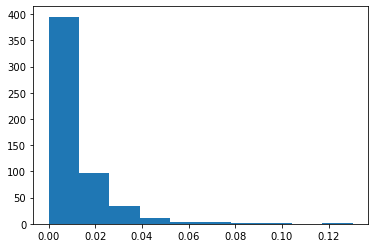

In [27]:
# plot histogram of distribution for prop crosswalk 
plt.hist(gsv_deaths_hlth['prop_crosswalk'])

(array([ 48., 217., 141.,  58.,  35.,  17.,  12.,  11.,   4.,   4.]),
 array([0.        , 0.08409334, 0.16818667, 0.25228001, 0.33637335,
        0.42046669, 0.50456002, 0.58865336, 0.6727467 , 0.75684003,
        0.84093337]),
 <BarContainer object of 10 artists>)

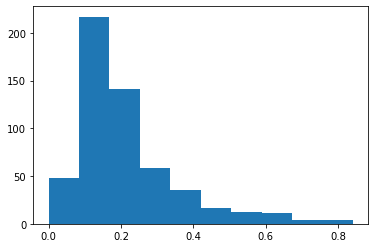

In [28]:
# plot histogram of distribution for prop not single family house
plt.hist(gsv_deaths_hlth['prop_not_single_family_house'])

(array([ 62., 124., 114.,  94.,  77.,  50.,  20.,   4.,   1.,   1.]),
 array([0.03267761, 0.06403028, 0.09538296, 0.12673563, 0.1580883 ,
        0.18944098, 0.22079365, 0.25214633, 0.283499  , 0.31485168,
        0.34620435]),
 <BarContainer object of 10 artists>)

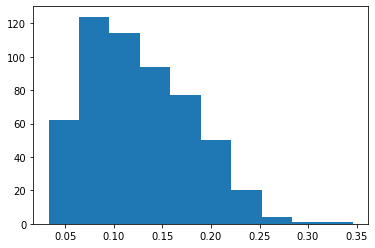

In [29]:
# plot histogram of distribution for uninsured adults
plt.hist(gsv_deaths_hlth['uninsured_adults'])

(array([297., 145.,  63.,  24.,   8.,   4.,   5.,   0.,   0.,   1.]),
 array([3.00716000e-05, 1.48089306e-03, 2.93171452e-03, 4.38253598e-03,
        5.83335744e-03, 7.28417890e-03, 8.73500036e-03, 1.01858218e-02,
        1.16366433e-02, 1.30874647e-02, 1.45382862e-02]),
 <BarContainer object of 10 artists>)

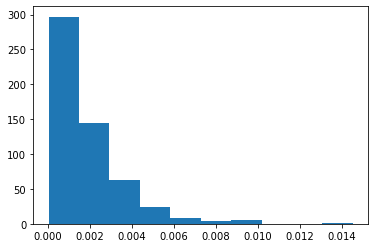

In [30]:
# plot histogram of distribution for mental health providers
plt.hist(gsv_deaths_hlth['mental_hlth'])

(array([404., 103.,  22.,   8.,   6.,   1.,   1.,   1.,   0.,   1.]),
 array([  16.5 ,  250.93,  485.36,  719.79,  954.22, 1188.65, 1423.08,
        1657.51, 1891.94, 2126.37, 2360.8 ]),
 <BarContainer object of 10 artists>)

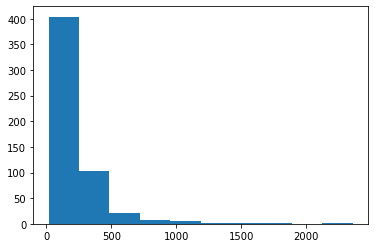

In [31]:
# plot histogram of distribution for HIV prevelance
plt.hist(gsv_deaths_hlth['HIV_prev'])

(array([518.,  16.,   7.,   2.,   1.,   0.,   0.,   1.,   1.,   1.]),
 array([    0. ,  1298.9,  2597.8,  3896.7,  5195.6,  6494.5,  7793.4,
         9092.3, 10391.2, 11690.1, 12989. ]),
 <BarContainer object of 10 artists>)

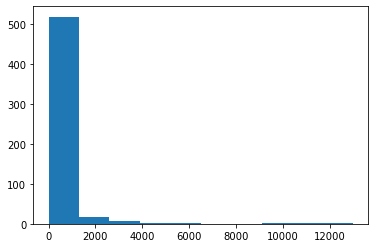

In [32]:
# plot histogram of distribution for excess deaths
plt.hist(gsv_deaths_hlth['excess_deaths'])

In [33]:
# reorganize data
codes = ['prop_crosswalk', 'prop_not_single_family_house','uninsured_adults','mental_hlth','HIV_prev']

X = gsv_deaths_hlth[codes].values
y = gsv_deaths_hlth['excess_deaths'].values.reshape((-1,1))

# standardize data
X_val = (X - X.mean(axis=0)) / X.std(axis=0)
y_val = (y - y.mean(axis=0)) / y.std(axis=0)

In [ ]:
# normalize data (min and max scaling?)


#### Fixed Effect Model

In [80]:
# create new data frame for counties using one hot encoding
counties = gsv_deaths_hlth.NAME.unique()
gsv_deaths_hlth_new = pd.concat([gsv_deaths_hlth,pd.get_dummies(gsv_deaths_hlth.NAME)],axis=1)
gsv_deaths_hlth_new.head()

,COUNTYNS,GEOID,NAME,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,state,broadband,uninsured_adults,primary_phys,home_ownership,mental_hlth,prevent_hosp_stay,HIV_prev,total_county_pop,total_deaths,expected_deaths,abnormal_deaths,excess_deaths,COVID19,Adams,Aitkin,Alamosa,Alcorn,Allegany,Allen,Andrew,Androscoggin,Anne Arundel,Appanoose,Arkansas,Atchison,Autauga,Baldwin,Baltimore,Barnstable,Barrow,Bartholomew,Barton,Bartow,Becker,Beltrami,Benton,Berkshire,Berrien,Black Hawk,Blaine,Bleckley,Blount,Bolivar,Bollinger,Bond,Bonner,Bonneville,Boone,Boulder,Bradford,Bristol,Broomfield,Broward,Brown,Buchanan,Buena Vista,Bullock,Bureau,Burke,Burlington,Butler,Calaveras,Calcasieu,Caldwell,Calhoun,Calvert,Camden,Candler,Cape May,Carroll,Carson City,Cascade,Cass,Catoosa,Cecil,Cedar,Chaffee,Chambers,Chariton,Charlton,Cherokee,Cheshire,Chickasaw,Chisago,Choctaw,Christian,Churchill,Cibola,Citrus,Claiborne,Clark,Clarke,Clay,Clayton,Cleburne,Clinton,Cloud,Cochise,Coconino,Colbert,Cole,Coles,Colfax,Columbia,Contra Costa,Cook,Coos,Cottonwood,Coweta,Cowley,Craighead,Crawford,Crisp,Custer,Dallas,Daviess,Dawson,DeKalb,DeSoto,Decatur,Delta,Denver,Dickinson,District of Columbia,Dixie,Dodge,Dorchester,Dougherty,Douglas,Dubois,Dubuque,Dukes,Duval,Eagle,Early,East Carroll,East Feliciana,Effingham,El Dorado,Elkhart,Ellis,Elmore,Escambia,Evangeline,Fayette,Fillmore,Flathead,Floyd,Ford,Forrest,Franklin,Frederick,Freeborn,Fremont,Fulton,Gallatin,Garfield,Garland,Geary,Gem,George,Gibson,Gilchrist,Gogebic,Goodhue,Gordon,Grafton,Grant,Greene,Greenlee,Greenwood,Habersham,Hale,Hall,Hamilton,Hampden,Hampshire,Hancock,Haralson,Harris,Harrison,Hart,Hartford,Hendry,Henry,Hernando,Highlands,Honolulu,Hot Spring,Howard,Hubbard,Hudson,Huerfano,Humboldt,Huntington,Iberville,Idaho,Independence,Ingham,Inyo,Iron,Iroquois,Itasca,Izard,Jackson,Jasper,Jefferson,Jefferson Davis,Jersey,Jo Daviess,Johnson,Kalkaska,Kanabec,Kandiyohi,Kane,Kankakee,Kendall,Kenton,Kings,Kootenai,La Plata,LaGrange,LaPorte,LaSalle,Labette,Laclede,Lafayette,Lake,Lamar,Lancaster,Lapeer,Lassen,Lawrence,Lee,Leelanau,Lewis and Clark,Limestone,Lincoln,Linn,Livingston,Logan,Lonoke,Los Angeles,Lowndes,Luce,Lyon,Macon,Madison,Mahaska,Manatee,Marengo,Maricopa,Marin,Marion,Mariposa,Marquette,Marshall,Martin,Mason,McDonald,McLean,McLeod,McPherson,Meeker,Menard,Mendocino,Menominee,Mercer,Meriwether,Miami,Miami-Dade,Middlesex,Mille Lacs,Miller,Mills,Mineral,Mississippi,Mobile,Moffat,Mono,Monroe,Monterey,Montezuma,Montgomery,Montmorency,Montrose,Morgan,Muscogee,Nantucket,Napa,Navajo,New Castle,New Haven,New London,Newaygo,Newton,Nez Perce,Nobles,Nye,Oceana,Ogemaw,Okeechobee,Olmsted,Orange,Oscoda,Otero,Ottawa,Ouachita,Owen,Palm Beach,Park,Pasco,Paulding,Pawnee,Peach,Pearl River,Perry,Piatt,Pickens,Pike,Pima,Pinal,Pinellas,Placer,Platte,Pointe Coupee,Polk,Pope,Porter,Posey,Pottawatomie,Poweshiek,Prince George's,Pueblo,Randolph,Rankin,Richland,Riley,Ripley,Rock Island,Roscommon,Rush,Sacramento,Sagadahoc,Saguache,Saline,San Bernardino,San Diego,San Francisco,San Miguel,Sanilac,Santa Barbara,Scott,Screven,Seminole,Sevier,Shasta,Shawnee,Shiawassee,Sierra,Silver Bow,Simpson,Solano,Sonoma,St. Bernard,St. Clair,St. Johns,St. Landry,St. Martin,Stephenson,Steuben,Stone,Suffolk,Sullivan,Summit,Sumner,Sumter,Sussex,Talbot,Talladega,Tallahatchie,Tangipahoa,Tift,Tippah,Tippecanoe,Tolland,Toombs,Trinity,Tuolumne,Tuscaloosa,Tuscola,Union,Upson,Van Buren,Vanderburgh,Ventura,Vermilion,Vigo,Volusia,Wabash,Wakulla,Waldo,Walton,Warren,Warrick,Waseca,Washington,Washtenaw,Wayne,Webster,Wells,White,White Pine,Wilcox,Wilkinson,Williamson,Windham,Winona,Winston,Worcester,Wright,Wyandotte,Yalobusha,Yell,Yuma
0,00835876,31109,Lancaster,Lancaster County,2169272970,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68140 41.04566, -96.68139 41.045...",0.865250,0.017866,0.226208,0.769947,0,0.448079,0.283

In [81]:
import sklearn as sk
from sklearn.linear_model import LinearRegression

In [83]:
# construct linear regression model
model = LinearRegression(fit_intercept=True)
x_mod = gsv_deaths_hlth_new.loc[:,np.concatenate((codes,counties))]
y_mod = gsv_deaths_hlth.excess_deaths

# fit our model to the data
model.fit(x_mod, y_mod)

pd.DataFrame.from_records(list(zip(np.concatenate((codes,counties)), model.coef_)))

LinearRegression()

,0,1
0,prop_crosswalk,64993.972619
1,prop_not_single_family_house,-888.686696
2,uninsured_adults,-771.544531
3,primary_phys,10640.128086
4,mental_hlth,7335.507364
5,prevent_hosp_stay,0.068350
6,HIV_prev,0.071435
7,Lancaster,36.112764
8,Sierra,253.770646
9,Clay,111.276379


In [84]:
# construct linear regression model
model = LinearRegression(fit_intercept=True)
x_mod = gsv_deaths_hlth_new.loc[:,np.concatenate((['prop_crosswalk'],counties))]
y_mod = gsv_deaths_hlth.excess_deaths

# fit our model to the data
model.fit(x_mod, y_mod)

pd.DataFrame.from_records(list(zip(np.concatenate((['prop_crosswalk'],counties)), model.coef_)))

LinearRegression()

,0,1
0,prop_crosswalk,6.025928e+04
1,Lancaster,-3.034779e+15
2,Sierra,-3.034779e+15
3,Clay,-3.034779e+15
4,Stone,-3.034779e+15
5,Jasper,-3.034779e+15
6,Henry,-3.034779e+15
7,Saguache,-3.034779e+15
8,Marengo,-3.034779e+15
9,Barton,-3.034779e+15


In [ ]:
# coefficient for age and the counties
pd.DataFrame.from_records(list(zip(np.concatenate((["age_scaled"],counties)), model.coef_)))

## Exploratory Plots

In [ ]:
# create histogram of available excess health data
y = excess_deaths['Excess']

# convert all excess death values that are 0 to 1
y[y==0] = 1

# remove all rows that = 1
y = y[y!= 1]

# plot histogram of log y
plt.hist(np.log(y))

# add title and axis labels

plt.title('Distribution of Excess Deaths')
plt.xlabel('Log(excess deaths)')
plt.ylabel('Frequency')

#plt.savefig('available excess deaths data.png')

<AxesSubplot:>

Text(0.5, 1.0, 'Proportion of Greenery by County')

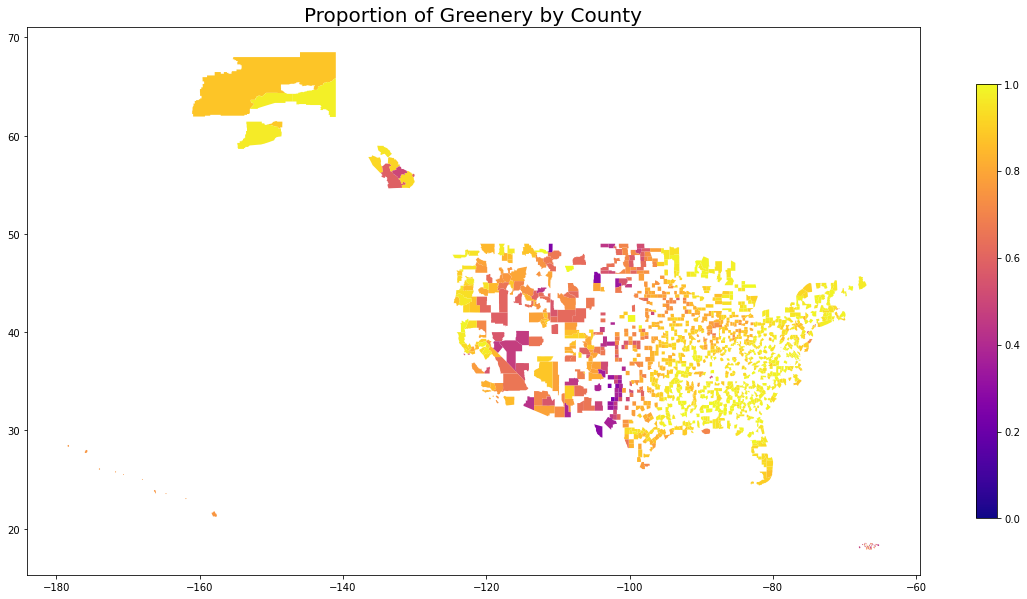

In [48]:
f, ax = plt.subplots(1,1,figsize=(20,20))
#counties.plot(ax=ax)
gsv_counties.plot(column='prop_green', ax=ax, k=5, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
#ax.set_facecolor('k')
plt.title('Proportion of Greenery by County', fontsize=20)

#ax.legend(title='This is My Legend Title')
#gsv_counties[gsv_counties.isna().any(axis=1)].plot(ax=ax, color='#D3D3D3')

<AxesSubplot:>

Text(0.5, 1.0, 'Proportion of Sidewalk by County')

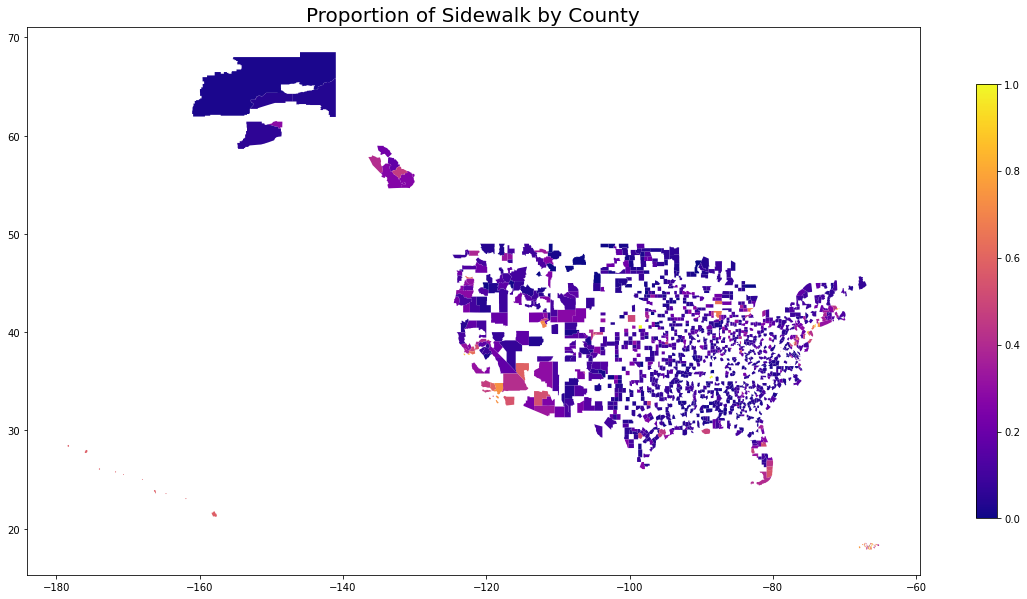

In [26]:
f, ax = plt.subplots(1,1,figsize=(20,20))
gsv_counties.plot('prop_sidewalk', ax=ax, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
#ax.set_facecolor('lightgray')

# add title
plt.title('Proportion of Sidewalk by County', fontsize=20)

#plt.savefig('not_single_family_homes.png')

<AxesSubplot:>

Text(0.5, 1.0, 'Proportion of Single Lane Roads by County')

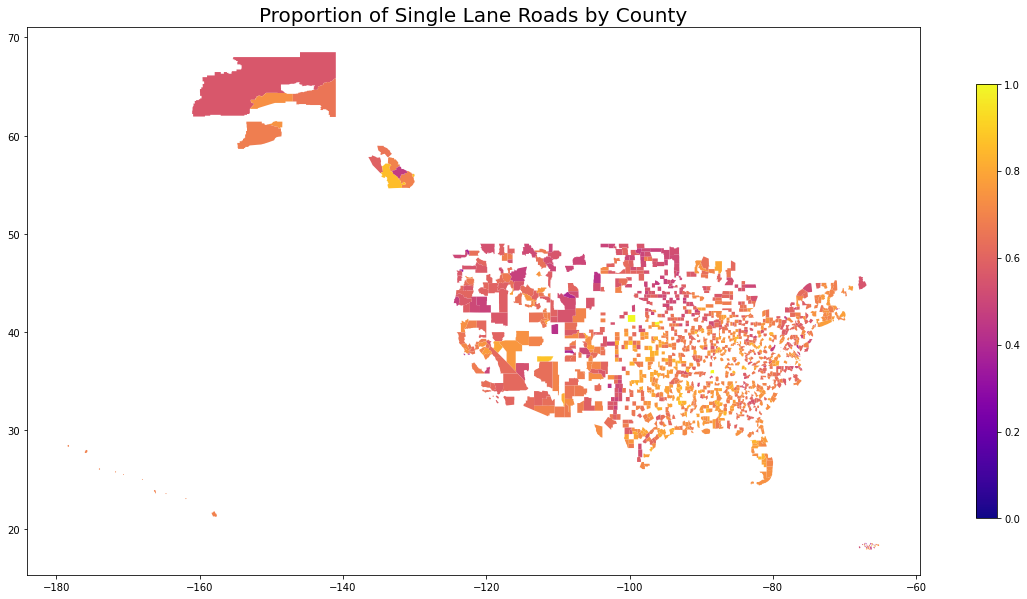

In [28]:
f, ax = plt.subplots(1,1,figsize=(20,20))
gsv_counties.plot('prop_single_lane', ax=ax, cmap='plasma', legend=True, legend_kwds={'shrink': 0.4})
#ax.set_facecolor('lightgray')

# add title
plt.title('Proportion of Single Lane Roads by County', fontsize=20)

#plt.savefig('not_single_family_homes.png')

In [61]:
gsv_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2979 entries, 0 to 2978
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   county                        2979 non-null   int64   
 1   prop_green                    2979 non-null   float64 
 2   prop_crosswalk                2979 non-null   float64 
 3   prop_not_single_family_house  2979 non-null   float64 
 4   prop_single_lane              2979 non-null   float64 
 5   prop_triple_lane              2979 non-null   int64   
 6   prop_visible_wires            2979 non-null   float64 
 7   prop_sidewalk                 2979 non-null   float64 
 8   prop_dilapidated_building     2979 non-null   float64 
 9   STATEFP                       2979 non-null   object  
 10  COUNTYFP                      2979 non-null   object  
 11  COUNTYNS                      2979 non-null   object  
 12  GEOID                         2979 non-n

In [64]:
excess_county_health[['State', 'excess_deaths']].groupby('State').sum()

,excess_deaths
State,
AK,432
AL,8690
AR,6861
AZ,14097
CA,39411
CO,6368
CT,4743
DC,2088
DE,933
